In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

In [3]:
#Import data into tensorflow dataset object
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "tomato",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [4]:
    class_names = dataset.class_names
    class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy)

(32, 256, 256, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 2, 4, 6, 0, 7, 9, 6, 6, 7, 4, 7, 1, 1, 0, 7, 0, 7, 0, 9, 0, 5,
       7, 2, 1, 4, 7, 9, 9, 1, 2, 5], dtype=int32)>>


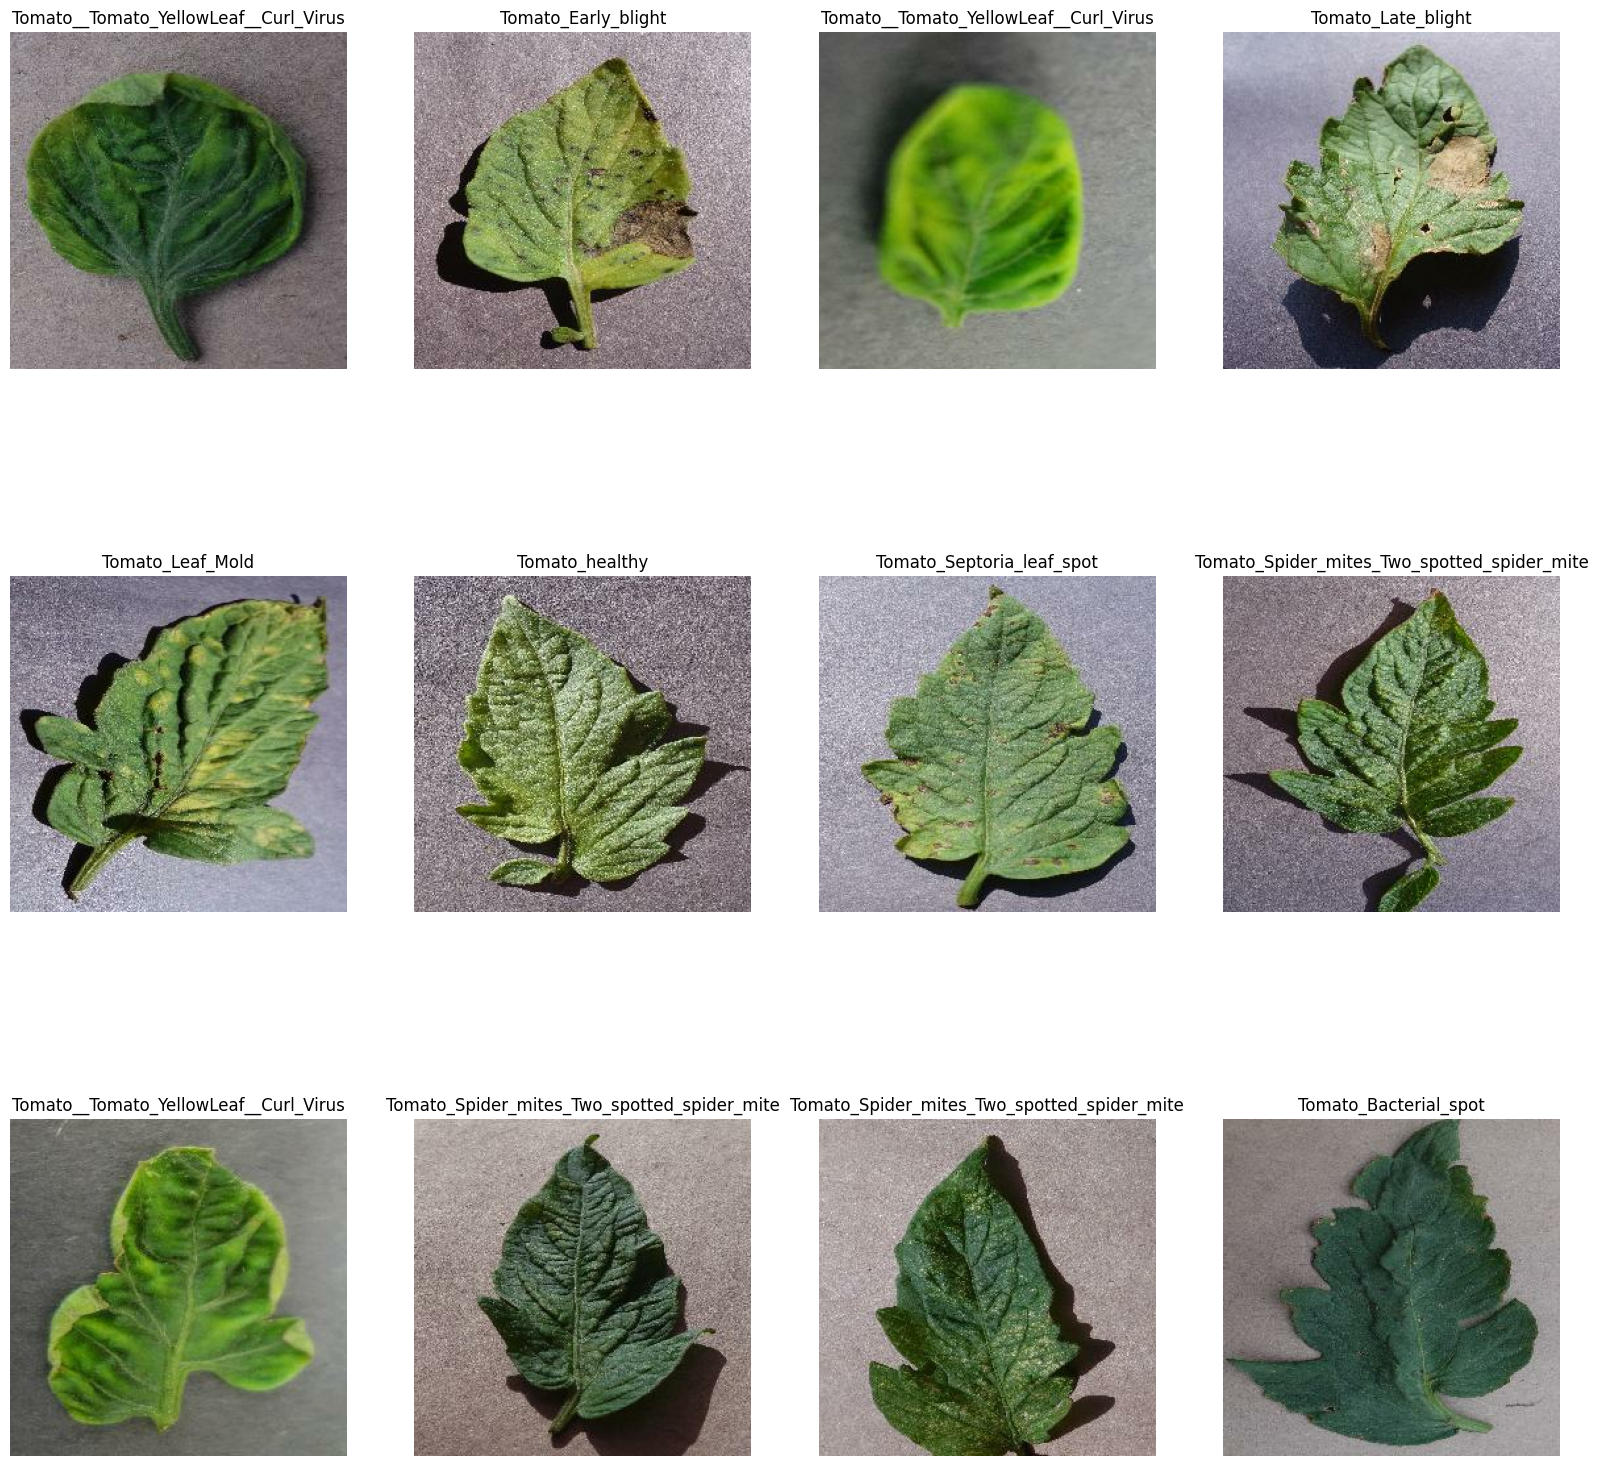

In [ ]:
plt.figure(figsize=(20, 20))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
#Function to Split Dataset
#Dataset should be bifurcated into 3 subsets, namely:
#Training: Dataset to be used while training 
#Validation: Dataset to be tested against while training 
#Test: Dataset to be tested against after we trained a model

In [9]:
len(dataset)

501

In [10]:
train_size = 0.8
len(dataset)*train_size

400.8

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

447

In [12]:
val_size=0.1
len(dataset)*val_size

50.1

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
 train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

400

In [17]:
len(val_ds)

50

In [18]:
len(test_ds)

51

In [19]:
#Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Building the Model
Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
#Data Augmentation
#Data Augmentation is needed when we have less data, 
#this boosts the accuracy of our model by augmenting the data.

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
#Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [26]:
#Compiling the Model
#We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
400/400 [==============================] - 306s 743ms/step - loss: 1.6745 - accuracy: 0.4038 - val_loss: 1.4205 - val_accuracy: 0.5025
Epoch 2/20
400/400 [==============================] - 3713s 9s/step - loss: 1.0733 - accuracy: 0.6282 - val_loss: 0.8844 - val_accuracy: 0.6956
Epoch 3/20
400/400 [==============================] - 291s 726ms/step - loss: 0.7659 - accuracy: 0.7336 - val_loss: 0.6787 - val_accuracy: 0.7675
Epoch 4/20
400/400 [==============================] - 12988s 33s/step - loss: 0.6062 - accuracy: 0.7855 - val_loss: 0.6366 - val_accuracy: 0.7794
Epoch 5/20
400/400 [==============================] - 627s 2s/step - loss: 0.4679 - accuracy: 0.8362 - val_loss: 0.4533 - val_accuracy: 0.8431
Epoch 6/20
400/400 [==============================] - 1091s 3s/step - loss: 0.4113 - accuracy: 0.8523 - val_loss: 0.6269 - val_accuracy: 0.8006
Epoch 7/20
400/400 [==============================] - 518s 1s/step - loss: 0.3590 - accuracy: 0.8687 - val_loss: 0.5123 - val_accur

In [45]:
scores = model.evaluate(test_ds)

51/51 [==============================] - 8s 152ms/step - loss: 0.2672 - accuracy: 0.9044


In [46]:
#Plotting the Accuracy and Loss Curves
history

In [47]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 400}

In [48]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [49]:
#loss, accuracy, val loss etc are a python list 
#containing values of loss, accuracy etc at the end of each epoch

type(history.history['loss'])

list

In [50]:
len(history.history['loss'])

20

In [51]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.674515962600708,
 1.0732985734939575,
 0.7658621072769165,
 0.6061880588531494,
 0.46786388754844666]

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [55]:
print(acc)

[0.4037500023841858, 0.6282031536102295, 0.733593761920929, 0.7855468988418579, 0.8361718654632568, 0.852343738079071, 0.8687499761581421, 0.8926562666893005, 0.8939843773841858, 0.9138281345367432, 0.9144531488418579, 0.9138281345367432, 0.928515613079071, 0.9296093583106995, 0.9359375238418579, 0.9332031011581421, 0.9434375166893005, 0.9417968988418579, 0.9453906416893005, 0.9467187523841858]


In [56]:
print (loss)

[1.674515962600708, 1.0732985734939575, 0.7658621072769165, 0.6061880588531494, 0.46786388754844666, 0.4113091230392456, 0.35903000831604004, 0.30374279618263245, 0.29685208201408386, 0.2483278512954712, 0.2426096349954605, 0.23857468366622925, 0.2035672515630722, 0.2028070092201233, 0.18334703147411346, 0.1901867687702179, 0.1634189933538437, 0.16359178721904755, 0.15347808599472046, 0.15450739860534668]


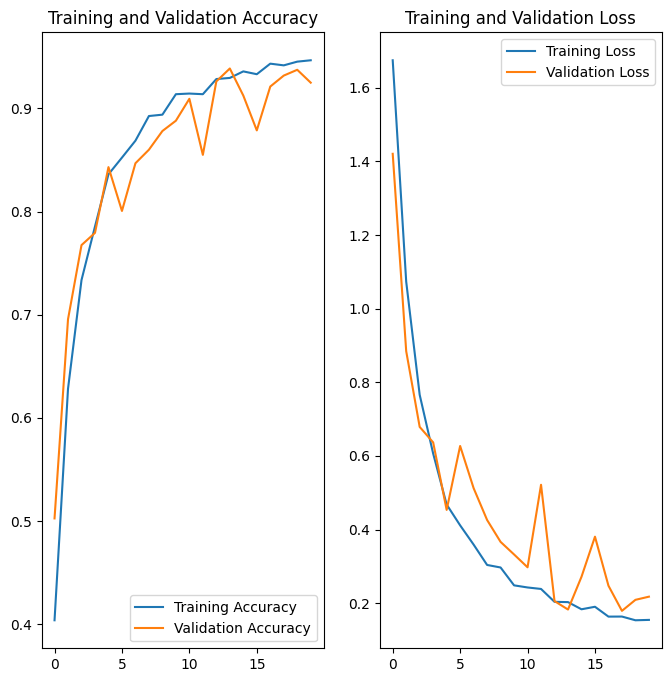

In [65]:
plt.figure(figsize=(8, 8))

# Left subplot: Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Right subplot: Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

first image to predict
actual label: Tomato_Leaf_Mold
1/1 [==============================] - 0s 295ms/step
predicted label: Tomato_Leaf_Mold


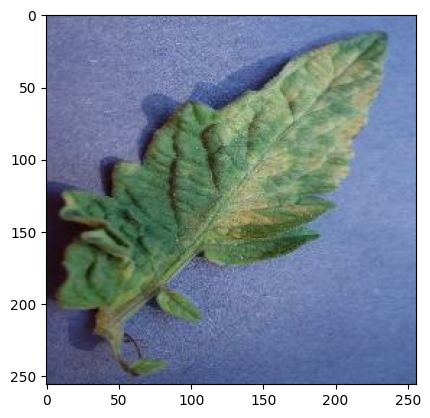

In [66]:
#Run prediction on a sample image
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [67]:
#Write a function for inference

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 15ms/step


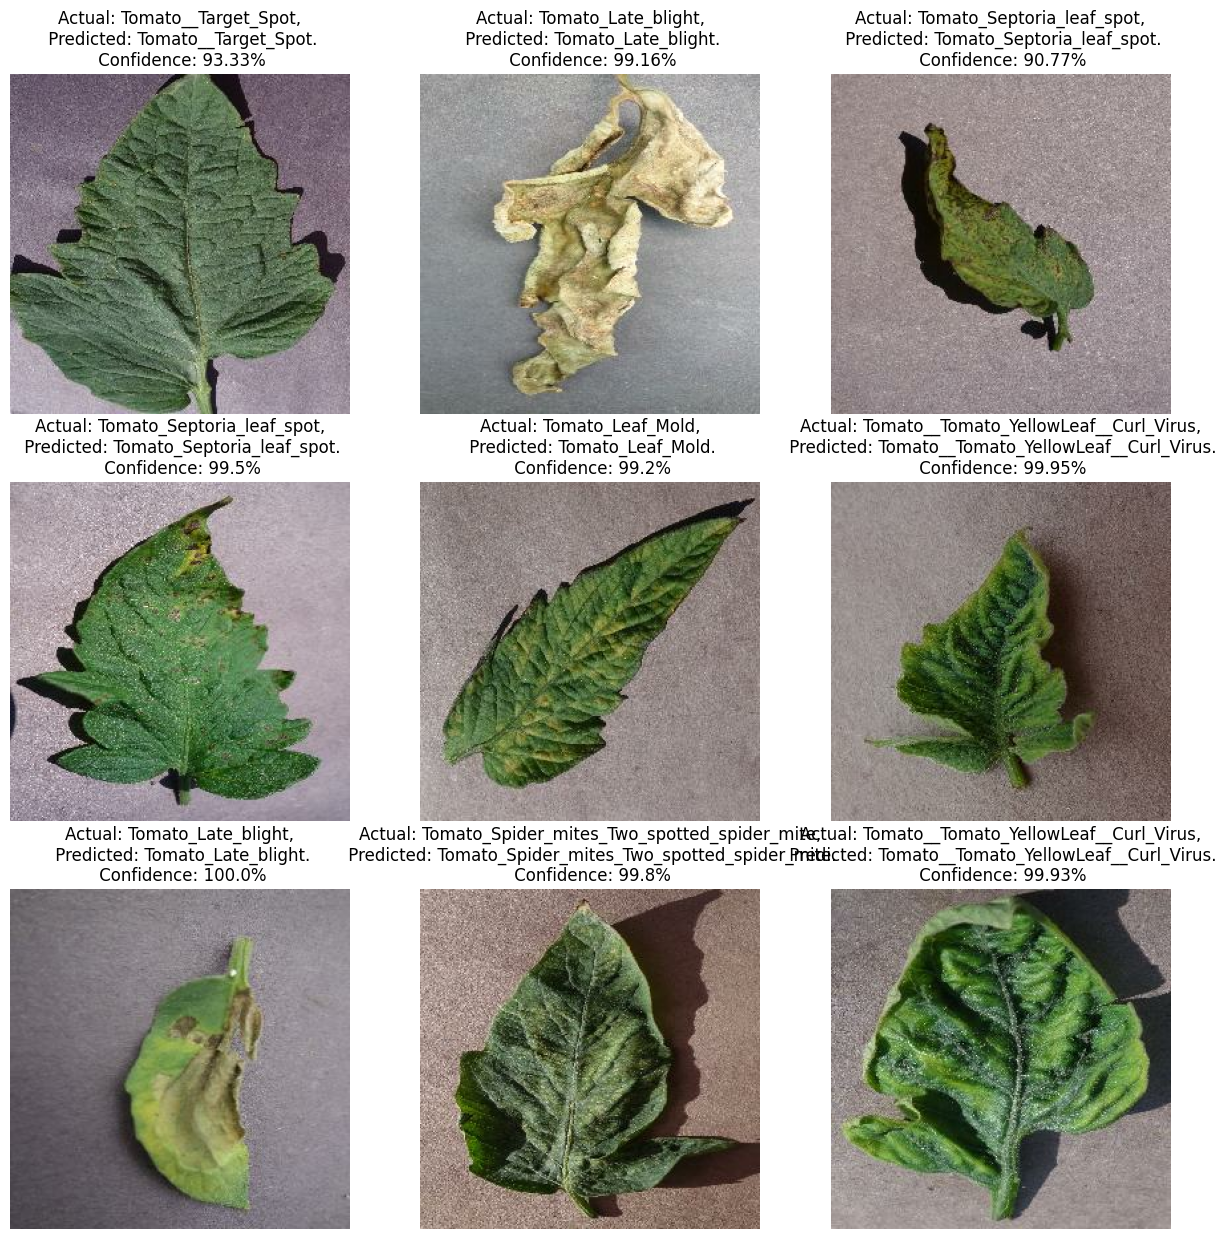

In [69]:
#Now run inference on few sample images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")